In [ ]:
# https://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gunzip t*-ubyte.gz
!pip install mlxtend

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
%matplotlib inline

In [2]:
''''
group member 1: Andrei Ilic
group member 2: Georgy Antonov

'''

# Provide paths to the local MNIST dataset
train_im_path  = '/Users/GA/Documents/Tübingen/DNNs/Homework/Code/mnist/train-images-idx3-ubyte'
train_lab_path = '/Users/GA/Documents/Tübingen/DNNs/Homework/Code/mnist/train-labels-idx1-ubyte'
test_im_path   = '/Users/GA/Documents/Tübingen/DNNs/Homework/Code/mnist/t10k-images-idx3-ubyte'
test_lab_path  = '/Users/GA/Documents/Tübingen/DNNs/Homework/Code/mnist/t10k-labels-idx1-ubyte'

# Load 
X_train, y_train = loadlocal_mnist(
                    images_path=train_im_path, 
                    labels_path=train_lab_path)

X_test, y_test = loadlocal_mnist(
                   images_path=test_im_path, 
                   labels_path=test_lab_path)

print('Dimensions: %s x %s' % (X_train.shape[0], X_train.shape[1]))

Dimensions: 60000 x 784


In [3]:
# split eval data from train data:
eval_data_size = 10000
train_data_size = 50000
test_data_size = 10000

X_eval = X_train[0:10000, :]
y_eval = y_train[0:10000]
X_train = X_train[10000:, :]
y_train = y_train[10000:]

# Convert to float
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)
print("x shapes:")
print(X_train.shape, X_eval.shape, X_test.shape)

# normalize train data from range 0 to 255 to range 0 to 1
X_train = X_train / 255
X_eval = X_eval / 255
X_test = X_test / 255

x shapes:
(50000, 784) (10000, 784) (10000, 784)


In [4]:
# transform to y to one hot encoded vectors:
# each row is one y vector
def make_one_hot(v):
    """
    :param v: vector of the length of the dataset containing class labels from 0 to 9
    :return: a matrix of dim(length dataset, 10), where the index of the corresponding label is set to one.
    """
    num_samples = len(v)
    num_labels  = len(np.unique(v))
    
    tmp = np.zeros((num_samples, num_labels))
    for i in range(len(v)):
        idx = int(v[i])
        tmp[i][idx] = 1
    v_one_hot = tmp
    return v_one_hot

y_train = make_one_hot(y_train)
y_eval = make_one_hot(y_eval)
y_test = make_one_hot(y_test)
print("y shapes:")
print(y_train.shape, y_eval.shape, y_test.shape)

y shapes:
(50000, 10) (10000, 10) (10000, 10)


In [5]:
# Can change these for training
batch_size = 100
epochs = 10
learning_rate = 0.01

# usually one would use a random weight initialization, but for reproducible results we use fixed weights
# Don't change these parameters
W = np.ones((784, 10)) * 0.01
b = np.ones((10)) * 0.01

def get_next_batch(iteration, batch_size, data, label):
    X = data[iteration * batch_size:(iteration + 1) * batch_size, :]
    y = label[iteration * batch_size:(iteration + 1) * batch_size, :]
    return X, y

def get_loss(y_hat, y):
    """
    :param y_hat: dim(batch_size,10)
    :param y:     dim(batch_size,10)
    :return:      loss value
    """
    batch_size = y_hat.shape[0]
    l = 0
    for row_y, row_y_hat in zip(y, y_hat):
        l += np.inner((row_y-row_y_hat), (row_y-row_y_hat))
    return l / batch_size

def get_accuracy(y_hat, y):
    """
    the accuracy for one image is one if the maximum of y_hat has the same index as the 1 in y
    :param y_hat:  dim(batch_size,10)
    :param y:      dim(batch_size,10)
    :return:       mean accuracy
    """
    batch_size = y_hat.shape[0]
    acc = 0
    for row_y, row_y_hat in zip(y, y_hat):
        if np.argmax(row_y) == np.argmax(row_y_hat):
            acc += 1        
    return acc / batch_size

def do_network_inference(x, W, b):  # over whole batch
    """
    :param x: dim(batchsize,784)
    :return: dim(batchsize,10)
    """
    batch_size = x.shape[0]
    b = np.repeat(b, batch_size, axis=0).reshape(10, batch_size)
    wx = np.matmul(np.transpose(W), np.transpose(x))
    y_hat = np.add(wx, b)
    return np.transpose(y_hat)

def get_delta_weights(y_hat, y, x_batch):
    """
    :param y_hat:   dim(batchsize,10)
    :param y:       dim(batchsize,10)
    :param x_batch: dim(batchsize,784)
    :return:        dim(784,10)
    """
    batch_size = x_batch.shape[0]    
    delta_w = np.zeros((10, 784))
    for row_y, row_y_hat, row_x_batch in zip(y, y_hat, x_batch):
        tmp = np.outer(2*(row_y_hat - row_y), row_x_batch)
        delta_w = np.add(delta_w, tmp)
        
    return np.transpose(delta_w) / batch_size

def get_delta_biases(y_hat, y):
    """
    :param y_hat:  dim(batchsize,10)
    :param y:      dim(batchsize,10)
    :return:       dim(10)
    """
    delta_b = np.zeros(10)
    batch_size = y.shape[0]
    for row_y, row_y_hat in zip(y, y_hat):
        delta_b = np.add(delta_b, 2*(row_y_hat - row_y))
    
    return delta_b / batch_size

def do_parameter_update(delta_w, delta_b, W, b, eta):
    """
    :param delta_w: dim(748,10)
    :param delta_b: dim(10)
    :param W:       dim(748,10)
    :param b:       dim(10)
    """
    # TODO update W and b
    W -= eta*delta_w
    b -= eta*delta_b
    return W, b

In [6]:
# do training and evaluation
mean_eval_losses  = []
mean_train_losses = []
mean_eval_accs    = []
mean_train_accs   = []

for epoch in range(epochs):
    # training
    mean_train_loss_per_epoch = 0
    mean_train_acc_per_epoch  = 0
    for i in range(train_data_size // batch_size):
        x, y = get_next_batch(i, batch_size, X_train, y_train)
        y_hat = do_network_inference(x, W, b)
        train_loss = get_loss(y_hat, y)
        train_accuracy = get_accuracy(y_hat, y)
        delta_w = get_delta_weights(y_hat, y, x)
        delta_b = get_delta_biases(y_hat, y)
        W, b = do_parameter_update(delta_w, delta_b, W, b, learning_rate)
        mean_train_loss_per_epoch += train_loss
        mean_train_acc_per_epoch  += train_accuracy
#         print("epoch: {0:d} \t iteration {1:d} \t train loss: {2:f}".format(epoch, i,train_loss))
        
    mean_train_loss_per_epoch /= ((train_data_size // batch_size))
    mean_train_acc_per_epoch  /= ((train_data_size // batch_size))
#     print("epoch:{0:d} \t mean train loss: {1:f} \t mean train acc: {2:f}".format(epoch,mean_train_loss_per_epoch,
#                                                                               mean_train_acc_per_epoch))
    # evaluation:
    mean_eval_loss_per_epoch = 0
    mean_eval_acc_per_epoch  = 0
    # Calculate the evaluation loss and accuracy
    for i in range(eval_data_size // batch_size):
        x, y = get_next_batch(i, batch_size, X_eval, y_eval)
        y_hat = do_network_inference(x, W, b)
        eval_loss = get_loss(y_hat, y)
        eval_accuracy = get_accuracy(y_hat, y)
        mean_eval_loss_per_epoch += eval_loss
        mean_eval_acc_per_epoch  += eval_accuracy
#         print("epoch: {0:d} \t iteration {1:d} \t eval loss: {2:f}".format(epoch, i,eval_loss))

    mean_eval_loss_per_epoch /= (eval_data_size // batch_size)
    mean_eval_acc_per_epoch  /= ((eval_data_size // batch_size))
#     print("epoch:{0:d} \t mean eval loss: {1:f} \t mean eval acc: {2:f}".format(epoch,mean_eval_loss_per_epoch,
#                                                                             mean_eval_acc_per_epoch))
    mean_eval_losses.append(mean_eval_loss_per_epoch)
    mean_train_losses.append(mean_train_loss_per_epoch)
    mean_eval_accs.append(mean_eval_acc_per_epoch)
    mean_train_accs.append(mean_train_acc_per_epoch)

final test loss: 0.398787 	 final test acc: 0.850900


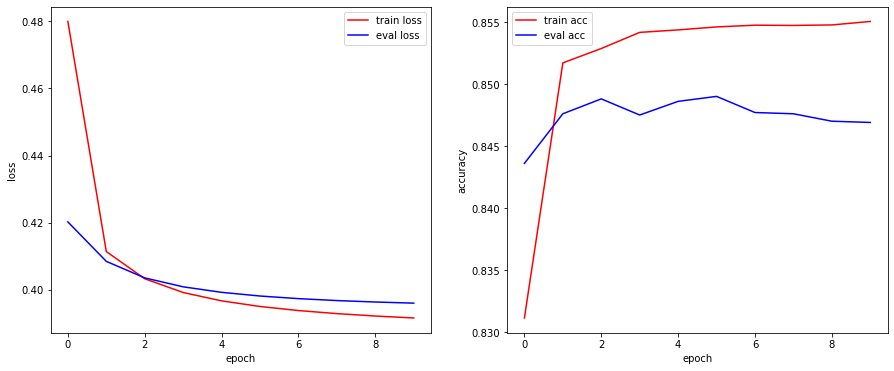

In [9]:
# Calculate the test loss and accuracy
mean_test_losses = []
mean_test_accs   = []

for epoch in range(epochs):
    # training
    mean_test_loss_per_epoch = 0
    mean_test_acc_per_epoch  = 0
    for i in range(test_data_size // batch_size):
        x, y = get_next_batch(i, batch_size, X_test, y_test)
        y_hat = do_network_inference(x, W, b)
        test_loss = get_loss(y_hat, y)
        test_accuracy = get_accuracy(y_hat, y)
        mean_test_loss_per_epoch += test_loss
        mean_test_acc_per_epoch  += test_accuracy
        
    mean_test_loss_per_epoch = mean_test_loss_per_epoch / ((test_data_size // batch_size))
    mean_test_acc_per_epoch  = mean_test_acc_per_epoch / ((test_data_size // batch_size))
    mean_test_losses.append(mean_test_loss_per_epoch)
    mean_test_accs.append(mean_test_acc_per_epoch)

final_mean_test_loss = np.sum(mean_test_losses)/epochs
final_mean_test_acc  = np.sum(mean_test_accs)/epochs
    
print("final test loss: {0:f} \t final test acc: {1:f}".format(final_mean_test_loss, final_mean_test_acc))

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(range(epochs), mean_train_losses, "r", label="train loss")
ax1.plot(range(epochs), mean_eval_losses, "b", label="eval loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.legend()

ax2.plot(range(epochs), mean_train_accs, "r", label="train acc")
ax2.plot(range(epochs), mean_eval_accs, "b", label="eval acc")
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()

plt.savefig('Results.png')